### reference
 - https://publikationen.bibliothek.kit.edu/1000133819
 - https://github.com/2Obe/BSData
 - https://www.sciencedirect.com/science/article/pii/S2352340921009185?via%3Dihub

In [1]:
# 基本ライブラリ
import gc
import glob
import os
import pickle
import random
import sys
import warnings

import albumentations as A
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

# ディープラーニング用のライブラリ
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

# データ前処理、拡張用のライブラリ
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import GradScaler, autocast
from torch.optim.lr_scheduler import (
    CosineAnnealingLR,
    CosineAnnealingWarmRestarts,
    LambdaLR,
    OneCycleLR,
    ReduceLROnPlateau,
    StepLR,
)
from torch.utils.data import DataLoader, Dataset

# プログレスバーのライブラリ
from tqdm.auto import tqdm
from tqdm.notebook import tqdm

tqdm.pandas()

# 画像処理用のライブラリ
import cv2
import imageio

# warning設定
import sklearn.exceptions
from PIL import Image

# 評価指標計算用のライブラリ
from sklearn.metrics import accuracy_score, f1_score

# データ分割のライブラリ
from sklearn.model_selection import StratifiedKFold

warnings.filterwarnings("ignore")

In [2]:
# seedの固定
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()

# デバイスの設定
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: cuda


In [3]:
# 画像のパスを取得
train_path = (
    "../input/10.35097-1511/10.35097-1511/data/dataset/training_data/training_data"
)
train_files = sorted(glob.glob(os.path.join(train_path, "*.png")))
print(f"Train data: {len(train_files)}")

Train data: 21835


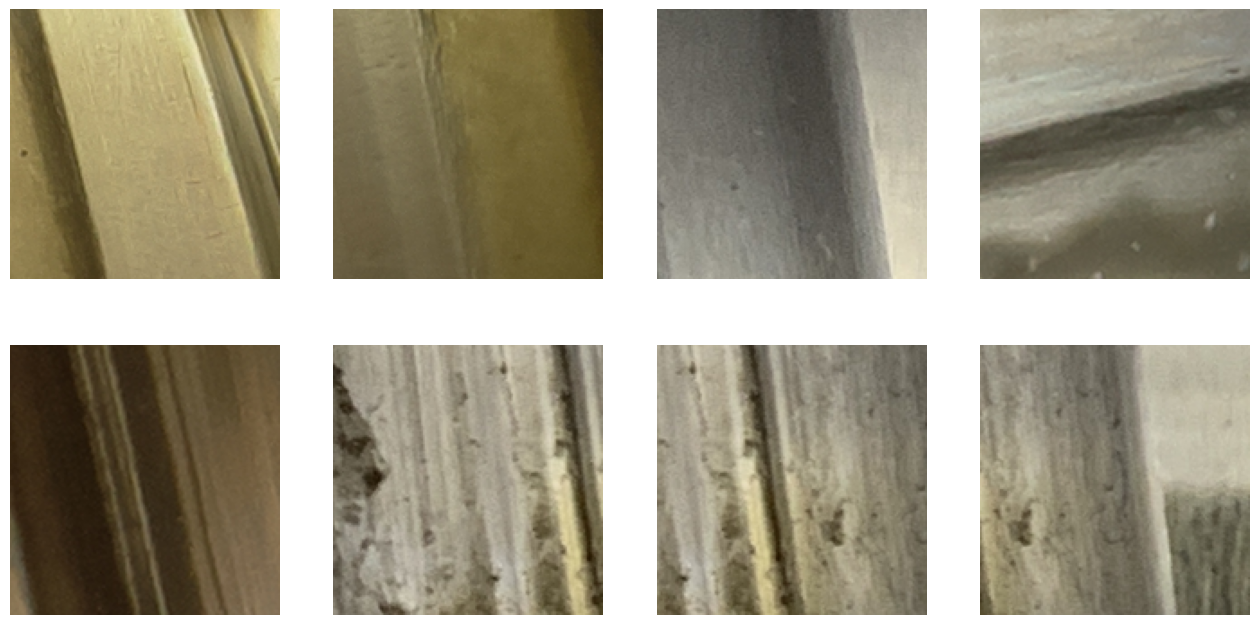

In [4]:
# train_filesでファイル名がNで始まる画像をランダムに表示
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_files[:8]):
    if "N" in file:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.axis("off")
plt.show()

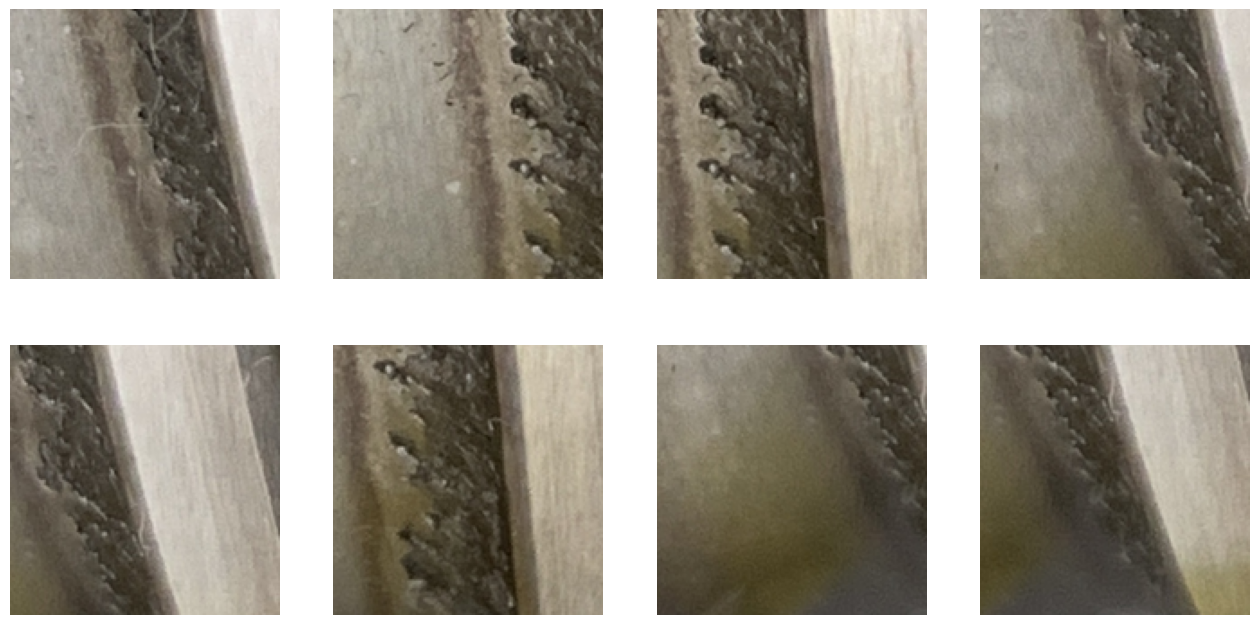

In [5]:
# train_filesでファイル名がPで始まる画像を後ろから表示
plt.figure(figsize=(16, 8))
for i, file in enumerate(train_files[-8:]):
    if "P" in file:
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 4, i + 1)
        plt.imshow(image)
        plt.axis("off")
plt.show()

In [6]:
# 画像のファイル名にPあるものは1, Nがあるものは0としてラベルを付与してtimmのモデルで2値分類を行う
train_df = pd.DataFrame(train_files, columns=["file_path"])
train_df["label"] = train_df["file_path"].apply(lambda x: 1 if "P" in x else 0)

# train_dfをサンプリング
train_df = train_df.sample(frac=0.03, random_state=42).reset_index(drop=True)

# train_dfを学習データと検証データに分割
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for fold, (train_index, valid_index) in enumerate(
    skf.split(train_df, train_df["label"])
):
    train_df.loc[valid_index, "fold"] = fold
train_df["fold"] = train_df["fold"].astype(int)

train_df

,file_path,label,fold
0,../input/10.35097-1511/10.35097-1511/data/data...,0,3
1,../input/10.35097-1511/10.35097-1511/data/data...,1,0
2,../input/10.35097-1511/10.35097-1511/data/data...,0,0
3,../input/10.35097-1511/10.35097-1511/data/data...,1,4
4,../input/10.35097-1511/10.35097-1511/data/data...,1,2
...,...,...,...
650,../input/10.35097-1511/10.35097-1511/data/data...,1,2
651,../input/10.35097-1511/10.35097-1511/data/data...,0,3
652,../input/10.35097-1511/10.35097-1511/data/data...,0,4
653,../input/10.35097-1511/10.35097-1511/data/data...,1,0


In [7]:
# データセットの作成
class ImageDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_path = self.df["file_path"].values[idx]
        image = cv2.imread(file_path)
        image = cv2.cvtColor(
            image, cv2.COLOR_BGR2RGB
        )  # cv2.imreadで読み込んだ画像はBGRで読み込まれるため、RGBに変換する。pilowで画像を読み込む場合は、変換の必要はない。
        if self.transform:
            image = self.transform(image=image)["image"]
        label = self.df["label"].values[idx]
        return image, label

# データ拡張の設定
transform = A.Compose(
    [
        A.Resize(256, 256),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.Normalize(),
        ToTensorV2(),
    ]
)

valid_transform = A.Compose(
    [A.Resize(256, 256), A.Normalize(), ToTensorV2()]
)  # 検証データにはデータ拡張を行わず、リサイズと正規化のみを行う。

# データセットの作成
train_dataset = ImageDataset(train_df[train_df["fold"] != 0], transform=transform)
valid_dataset = ImageDataset(train_df[train_df["fold"] == 0], transform=valid_transform)

# データローダーの作成
train_loader = DataLoader(
    train_dataset, batch_size=64, shuffle=True
)  # shuffle=Trueに設定すると、エポックごとに訓練データがランダムにシャッフルされる。これにより、モデルが訓練データを学習する順序が毎回異なり、過学習を防ぐ効果がある。
valid_loader = DataLoader(
    valid_dataset, batch_size=64, shuffle=False
)  # shuffle=Falseに設定すると、データがシャッフルされない。検証データはシャッフルする必要がないため、Falseに設定する。

# モデルの作成
model = timm.create_model('resnet18', pretrained=False, num_classes=1) #num_clases=1として2値分類を行うため、最終層の出力ユニット数を1に設定する。
model = model.to(device)

# 損失関数の設定
criterion = nn.BCEWithLogitsLoss()

# オプティマイザの設定
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)

# 学習率スケジューラの設定
num_epochs = 50
scaler = GradScaler()
scheduler = CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=1e-6)

# モデル保存のための初期化
best_valid_loss = float('inf')
save_path = 'best_model.pth'

# 損失を記録するリスト
train_losses = []
valid_losses = []

# 学習の実行
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        optimizer.zero_grad()
        with autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # 検証ループ
    model.eval()
    valid_running_loss = 0.0
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            images = images.to(device)
            labels = labels.to(device).float().view(-1, 1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
    valid_loss = valid_running_loss / len(valid_loader)
    valid_losses.append(valid_loss)
    
    # 改善された場合にモデルを保存
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), save_path)
        print(f"Model saved at epoch {epoch+1} with validation loss {valid_loss:.4f}")
    
    print(f"Epoch: {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}")
    
    # スケジューラのステップ
    scheduler.step()

print(f"Best validation loss: {best_valid_loss:.4f}, Model saved to {save_path}")


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 1 with validation loss 0.6899
Epoch: 1/50, Train Loss: 0.6646, Valid Loss: 0.6899


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 2/50, Train Loss: 0.6154, Valid Loss: 0.7062


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 3/50, Train Loss: 0.5829, Valid Loss: 0.7306


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 4/50, Train Loss: 0.5518, Valid Loss: 0.7209


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 5 with validation loss 0.6513
Epoch: 5/50, Train Loss: 0.5280, Valid Loss: 0.6513


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 6 with validation loss 0.5794
Epoch: 6/50, Train Loss: 0.5227, Valid Loss: 0.5794


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 7 with validation loss 0.5009
Epoch: 7/50, Train Loss: 0.5028, Valid Loss: 0.5009


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 8 with validation loss 0.4627
Epoch: 8/50, Train Loss: 0.4972, Valid Loss: 0.4627


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 9 with validation loss 0.4230
Epoch: 9/50, Train Loss: 0.4913, Valid Loss: 0.4230


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 10 with validation loss 0.4164
Epoch: 10/50, Train Loss: 0.4573, Valid Loss: 0.4164


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 11 with validation loss 0.3941
Epoch: 11/50, Train Loss: 0.4379, Valid Loss: 0.3941


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 12 with validation loss 0.3909
Epoch: 12/50, Train Loss: 0.4217, Valid Loss: 0.3909


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 13 with validation loss 0.3625
Epoch: 13/50, Train Loss: 0.4190, Valid Loss: 0.3625


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 14 with validation loss 0.3607
Epoch: 14/50, Train Loss: 0.4218, Valid Loss: 0.3607


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 15/50, Train Loss: 0.3980, Valid Loss: 0.3747


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 16 with validation loss 0.3483
Epoch: 16/50, Train Loss: 0.3861, Valid Loss: 0.3483


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 17 with validation loss 0.3232
Epoch: 17/50, Train Loss: 0.3618, Valid Loss: 0.3232


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 18 with validation loss 0.3183
Epoch: 18/50, Train Loss: 0.3843, Valid Loss: 0.3183


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 19/50, Train Loss: 0.3813, Valid Loss: 0.3255


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 20/50, Train Loss: 0.3502, Valid Loss: 0.3364


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 21/50, Train Loss: 0.4167, Valid Loss: 0.3467


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 22/50, Train Loss: 0.3446, Valid Loss: 0.3274


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 23 with validation loss 0.3062
Epoch: 23/50, Train Loss: 0.3643, Valid Loss: 0.3062


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 24 with validation loss 0.2908
Epoch: 24/50, Train Loss: 0.3634, Valid Loss: 0.2908


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 25/50, Train Loss: 0.3529, Valid Loss: 0.3143


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 26/50, Train Loss: 0.3724, Valid Loss: 0.2947


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 27/50, Train Loss: 0.3547, Valid Loss: 0.3039


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 28/50, Train Loss: 0.3416, Valid Loss: 0.3427


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 29/50, Train Loss: 0.3330, Valid Loss: 0.3179


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 30 with validation loss 0.2882
Epoch: 30/50, Train Loss: 0.3597, Valid Loss: 0.2882


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 31 with validation loss 0.2858
Epoch: 31/50, Train Loss: 0.3159, Valid Loss: 0.2858


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 32 with validation loss 0.2776
Epoch: 32/50, Train Loss: 0.3272, Valid Loss: 0.2776


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 33 with validation loss 0.2737
Epoch: 33/50, Train Loss: 0.3014, Valid Loss: 0.2737


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 34/50, Train Loss: 0.2815, Valid Loss: 0.2758


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 35 with validation loss 0.2651
Epoch: 35/50, Train Loss: 0.3155, Valid Loss: 0.2651


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Model saved at epoch 36 with validation loss 0.2603
Epoch: 36/50, Train Loss: 0.2907, Valid Loss: 0.2603


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 37/50, Train Loss: 0.3211, Valid Loss: 0.2659


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 38/50, Train Loss: 0.2772, Valid Loss: 0.2906


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 39/50, Train Loss: 0.2968, Valid Loss: 0.2679


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 40/50, Train Loss: 0.2881, Valid Loss: 0.2709


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 41/50, Train Loss: 0.2843, Valid Loss: 0.2646


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 42/50, Train Loss: 0.2933, Valid Loss: 0.2689


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 43/50, Train Loss: 0.2929, Valid Loss: 0.2648


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 44/50, Train Loss: 0.2862, Valid Loss: 0.2637


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 45/50, Train Loss: 0.2902, Valid Loss: 0.2714


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 46/50, Train Loss: 0.3006, Valid Loss: 0.2645


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 47/50, Train Loss: 0.3182, Valid Loss: 0.2621


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 48/50, Train Loss: 0.2992, Valid Loss: 0.2628


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 49/50, Train Loss: 0.2885, Valid Loss: 0.2652


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 50/50, Train Loss: 0.2736, Valid Loss: 0.2636
Best validation loss: 0.2603, Model saved to best_model.pth


In [8]:
# 検証データにおける正解率とF1スコアを計算
valid_preds = []
valid_labels = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(valid_loader):
        images = images.to(device)
        labels = labels.to(device).float().view(-1, 1)
        outputs = model(images)
        preds = torch.sigmoid(outputs).cpu().numpy()
        valid_preds.extend(preds)
        valid_labels.extend(labels.cpu().numpy())
valid_preds = np.array(valid_preds).flatten()

  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
# valid_predsとvalid_labelsを比較して、scikit-learnのモジュールを使用して正解率とF1スコアを計算
valid_preds = np.where(valid_preds > 0.5, 1, 0)
valid_labels = np.array(valid_labels).flatten()
accuracy = accuracy_score(valid_labels, valid_preds)
f1 = f1_score(valid_labels, valid_preds)
print(f"Accuracy: {accuracy:.4f}, F1: {f1:.4f}")

Accuracy: 0.8931, F1: 0.8833


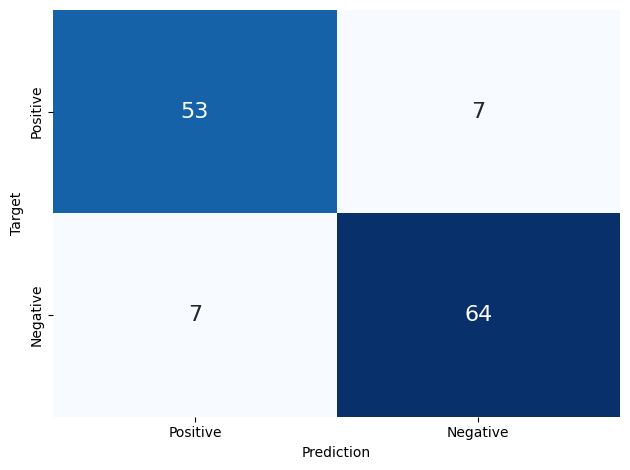

In [10]:
# confusion matrixを左上がTrue Positive、右上がFalse Positive、左下がFalse Negative、右下がTrue Negativeになるように可視化
cm = confusion_matrix(valid_labels, valid_preds)
sns.heatmap(cm[::-1, ::-1], annot=True, cmap='Blues', fmt='d', cbar=False, annot_kws={'size': 16})
plt.xlabel('Prediction')
plt.ylabel('Target')
plt.xticks([0.5, 1.5], ['Positive', 'Negative'])
plt.yticks([0.5, 1.5], ['Positive', 'Negative'])
plt.tight_layout()
plt.show()